In [1]:
import torch
assert torch.cuda.is_available()
cuda_device = torch.device("cuda:0")
torch.cuda.set_device(cuda_device)

args = {}
args['lr'] = 1e-4
args['b_s'] = 32
args['z_dim'] = 100
args['epoch'] = 1000

In [2]:
import torchvision.datasets as ds
from torchvision import transforms
train_data = ds.MNIST('/home/yuhong_zhong/sdb2/wangyezhen/datasets/', train=True, transform=transforms.Compose([
                       transforms.ToTensor()]))
train_loader = torch.utils.data.DataLoader(train_data, batch_size=args['b_s'], shuffle=True)

In [3]:
from Discriminator import Discriminator
from Generator import Generator
Criterion = torch.nn.BCELoss().to(cuda_device)
D_real_label = torch.ones(args['b_s'], 1, dtype=torch.float32).to(cuda_device)
D_fake_label = torch.zeros(args['b_s'], 1, dtype=torch.float32).to(cuda_device)
D = Discriminator(28 * 28).to(cuda_device)
G = Generator(args['z_dim']).to(cuda_device)
D_optimizer = torch.optim.Adam(D.parameters(), lr=args['lr'])
G_optimizer = torch.optim.Adam(G.parameters(), lr=args['lr'])

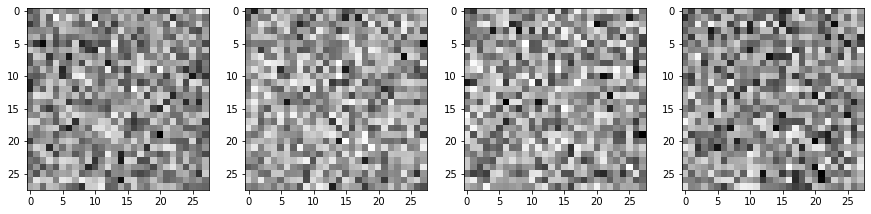

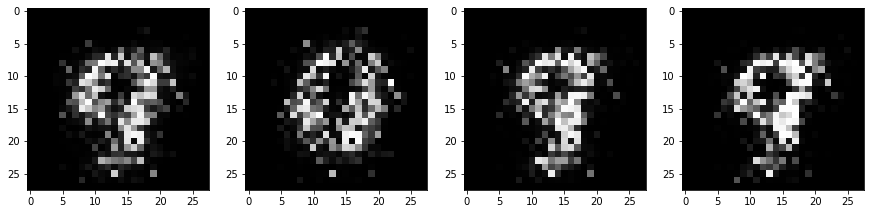

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
step = 0
for i in range(args['epoch']):
    for train_img, gt in train_loader:
        
        # eval
        if step % 5000 == 0:
            z_prior = torch.randn(4, args['z_dim'], dtype=torch.float32).to(cuda_device)
            g_z = G(z_prior)
            samples = torch.squeeze(g_z).view(4, 28, 28).data.cpu().numpy()
            fig, (fig_0, fig_1, fig_2, fig_3) = plt.subplots(1, 4, figsize=(15, 4))
            fig_0.imshow(samples[0], cmap='Greys_r')
            fig_1.imshow(samples[1], cmap='Greys_r')
            fig_2.imshow(samples[2], cmap='Greys_r')
            fig_3.imshow(samples[3], cmap='Greys_r')
            plt.show()
            plt.close(fig)
        
        # update discriminator
        train_img = train_img.to(cuda_device)
        z_prior = torch.randn(args['b_s'], args['z_dim'], dtype=torch.float32).to(cuda_device)

        g_z = G(z_prior)
        d_real = D(train_img.view(args['b_s'], 28 * 28))
        d_fake = D(g_z)

        D_optimizer.zero_grad()
        d_real_loss = Criterion(d_real, D_real_label)
        d_fake_loss = Criterion(d_fake, D_fake_label)
        d_loss =  d_real_loss + d_fake_loss
        d_loss.backward()
        D_optimizer.step()

        # update generator
        z_prior = torch.randn(args['b_s'], args['z_dim'], dtype=torch.float32).to(cuda_device)
        g_z = G(z_prior)
        d_fake = D(g_z)

        G_optimizer.zero_grad()
        g_loss = Criterion(d_fake, D_real_label)
        g_loss.backward()
        G_optimizer.step()
        step += 1